## Happiness Index KNN Model

Based on parameter studies, different models with different features are calculated and analysed in this notebook. 

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import get_scorer_names, r2_score, mean_absolute_error, mean_absolute_percentage_error 
from sklearn.model_selection import RandomizedSearchCV

Import dataset

In [58]:
df = pd.read_csv("../data/life_ladder_gdi_eys_mys.txt")
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_name                      1993 non-null   object 
 1   year                              1993 non-null   int64  
 2   life_ladder                       1993 non-null   float64
 3   log_gdp_per_capita                1993 non-null   float64
 4   social_support                    1993 non-null   float64
 5   healthy_life_expectancy_at_birth  1993 non-null   float64
 6   freedom_to_make_life_choices      1993 non-null   float64
 7   perceptions_of_corruption         1993 non-null   float64
 8   positive_affect                   1993 non-null   float64
 9   negative_affect                   1993 non-null   float64
 10  gdi_year                          1908 non-null   float64
 11  eys_year                          1946 non-null   float64
 12  mys_ye

The following features will be added one by one to improve the model:

### Features from Happiness:
+ log_gdp_per_capita
+ social_support
+ healthy_life_expectancy_at_birth
+ freedom_to_make_life_choices
+ perception of corruption
+ positive affect
+ negative affect

### Feature from Human Development index:
+ mys (median years of school)



In [60]:
df.drop(['country_name', 'year', 'gdi_year', 'eys_year' ], axis=1, inplace= True)
df.dropna(inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries, 0 to 1992
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   life_ladder                       1946 non-null   float64
 1   log_gdp_per_capita                1946 non-null   float64
 2   social_support                    1946 non-null   float64
 3   healthy_life_expectancy_at_birth  1946 non-null   float64
 4   freedom_to_make_life_choices      1946 non-null   float64
 5   perceptions_of_corruption         1946 non-null   float64
 6   positive_affect                   1946 non-null   float64
 7   negative_affect                   1946 non-null   float64
 8   mys_year                          1946 non-null   float64
dtypes: float64(9)
memory usage: 152.0 KB


Model data, Train-Test-Split, Scaling

In [61]:
features = ['log_gdp_per_capita',
            'social_support',
            'healthy_life_expectancy_at_birth',
            'freedom_to_make_life_choices',
            'perceptions_of_corruption',
            'positive_affect',
            'mys_year']
X = df[features]
y = df['life_ladder']

In [62]:
X.columns

Index(['log_gdp_per_capita', 'social_support',
       'healthy_life_expectancy_at_birth', 'freedom_to_make_life_choices',
       'perceptions_of_corruption', 'positive_affect', 'mys_year'],
      dtype='object')

In [63]:
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=123)

In [64]:
X_train_all.shape

(1459, 7)

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all)
X_test_scaled = scaler.transform(X_test_all)

In [66]:
X_train_scaled[:,[0,1,2]]

array([[ 0.97657945,  0.8294818 ,  0.71269823],
       [-1.40701203, -0.08815385, -2.0956677 ],
       [ 1.43573169,  0.59187971,  0.87111888],
       ...,
       [ 0.85744336,  0.62465241,  0.77030574],
       [-0.72437091, -1.02217585, -0.96872086],
       [-1.05569099, -1.34990287, -0.48265752]])

In [67]:
def adjusted_r2(y,y_pred, X):
    adjusted_r2 = 1 - ((1 - r2_score(y, y_pred)) * (len(X) - 1) / (len(X) - X.shape[1] - 1))
    return adjusted_r2 

In [68]:
def train_model(model_name, ModelClass, X_train, X_test, Y_train, Y_test, **kwargs):
    model = ModelClass(**kwargs)
    model.fit(X_train, Y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
        
    r2_test = adjusted_r2(Y_test, y_pred_test, X_test).round(3)
    r2_train = adjusted_r2(Y_train, y_pred_train, X_train).round(3)
        
    mae_test = mean_absolute_error(Y_test, y_pred_test).round(3)
    mape_test = mean_absolute_percentage_error(Y_test, y_pred_test).round(3)
    mae_train = mean_absolute_error(Y_train, y_pred_train).round(3)
    mape_train = mean_absolute_percentage_error(Y_train, y_pred_train).round(3)
    
    delta_mae = abs(mae_train - mae_test).round(3)
    delta_r2 = abs(r2_train - r2_test).round(3)

    metrics_dict={'model_name': model_name,
                      'test_r2':r2_test,
                      'test_mae': mae_test, 
                      'test_mape':mape_test,
                      'delta_MAE':delta_mae,
                      'delta_r2': delta_r2,
                      'train_r2':r2_train, 
                      'train_mae': mae_train, 
                      'train_mape':mape_train}

    return model, metrics_dict

+ log_gdp_per_capita 01 (basic model)
+ social_support 02
+ healthy_life_expectancy_at_birth 03
+ freedom_to_make_life_choices 04
+ perception of corruption 05
+ positive affect 06
+ mys 07


In [69]:
metrics_lst = []
sns.set_style("white")


In [70]:
knn_01, metrics_01 = train_model('Basemodel GDP',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0]],
                                   X_test_scaled[:,[0]],
                                   y_train,
                                   y_test,
                                   n_neighbors=10, p=1, weights='uniform')
metrics_lst.append(metrics_01)

In [71]:
knn_02, metrics_02 = train_model('Social Support',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0,1]],
                                   X_test_scaled[:,[0,1]],
                                   y_train,
                                   y_test,
                                   n_neighbors=10, p=1, weights='uniform')
metrics_lst.append(metrics_02)

In [72]:
knn_03, metrics_03 = train_model('Healthy Life Exp. Birth',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0,1,2]],
                                   X_test_scaled[:,[0,1,2]],
                                   y_train,
                                   y_test,
                                   n_neighbors=10, p=1, weights='uniform')
metrics_lst.append(metrics_03)

In [73]:
knn_04, metrics_04 = train_model('Freedom 2 Life Choices',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0,1,2,3]],
                                   X_test_scaled[:,[0,1,2,3]],
                                   y_train,
                                   y_test,
                                   n_neighbors=10, p=1, weights='uniform')
metrics_lst.append(metrics_04)

In [74]:
knn_05, metrics_05 = train_model('Perception of Corruption',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0,1,2,3,4]],
                                   X_test_scaled[:,[0,1,2,3,4]],
                                   y_train,
                                   y_test,
                                   n_neighbors=10, p=1, weights='uniform')
metrics_lst.append(metrics_05)

In [75]:
knn_06, metrics_06 = train_model('Positive Affect',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0,1,2,3,4,5]],
                                   X_test_scaled[:,[0,1,2,3,4,5]],
                                   y_train,
                                   y_test,
                                   n_neighbors=10, p=1, weights='uniform')
metrics_lst.append(metrics_06)

In [76]:
knn_07, metrics_07 = train_model('Years of School',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0,1,2,3,4,5,6]],
                                   X_test_scaled[:,[0,1,2,3,4,5,6]],
                                   y_train,
                                   y_test,
                                   n_neighbors=10, p=1, weights='uniform')
metrics_lst.append(metrics_07)

In [77]:
knn_opt, metrics_opt = train_model('Optimal Model',
                                   KNeighborsRegressor,
                                   X_train_scaled[:,[0,1,2,3,4,5,6]],
                                   X_test_scaled[:,[0,1,2,3,4,5,6]],
                                   y_train,
                                   y_test,
                                   n_neighbors=5, p=1, algorithm= 'brute', weights = 'uniform')
metrics_lst.append(metrics_opt)

In [78]:
metrics_df = pd.DataFrame(metrics_lst)
metrics_df

,model_name,test_r2,test_mae,test_mape,delta_MAE,delta_r2,train_r2,train_mae,train_mape
0,Basemodel GDP,0.621,0.526,0.104,0.058,0.108,0.729,0.468,0.093
1,Social Support,0.739,0.443,0.088,0.056,0.066,0.805,0.387,0.077
2,Healthy Life Exp. Birth,0.778,0.401,0.080,0.052,0.064,0.842,0.349,0.070
3,Freedom 2 Life Choices,0.798,0.385,0.077,0.051,0.052,0.850,0.334,0.067
4,Perception of Corruption,0.819,0.360,0.072,0.034,0.039,0.858,0.326,0.066
5,Positive Affect,0.842,0.341,0.069,0.031,0.029,0.871,0.310,0.063
6,Years of School,0.853,0.330,0.067,0.034,0.027,0.880,0.296,0.061
7,Optimal Model,0.876,0.294,0.059,0.045,0.037,0.913,0.249,0.051


/var/folders/m_/n8mjr4pn3vl8nz5my8xxr76r0000gn/T/ipykernel_44282/3689365751.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


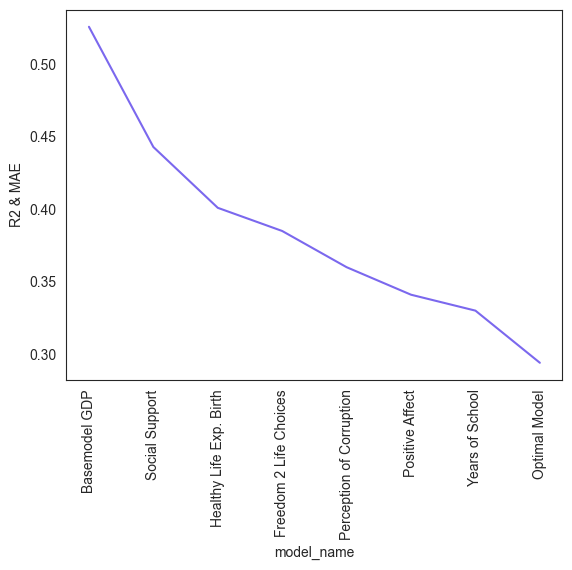

In [79]:
#g=sns.lineplot(data = metrics_df, x = 'model_name', y = 'test_r2', color = 'darkorange')
g=sns.lineplot(data = metrics_df, x = 'model_name', y = 'test_mae', color = 'mediumslateblue')
#g=sns.lineplot(data = metrics_df, x = 'model_name', y = 'train_r2',linestyle='dashed', color = 'darkorange')
#g=sns.lineplot(data = metrics_df, x = 'model_name', y = 'train_mae', linestyle='dashed', color = 'mediumslateblue')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylabel='R2 & MAE')
plt.show();

/var/folders/m_/n8mjr4pn3vl8nz5my8xxr76r0000gn/T/ipykernel_44282/770714745.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=0)


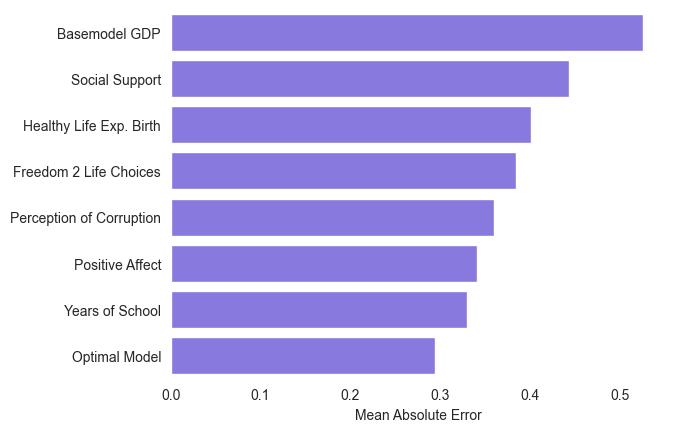

In [80]:
g=sns.barplot(data = metrics_df.sort_values(by='test_mae', ascending = False), y = 'model_name', x = 'test_mae', color = 'mediumslateblue')
g.set_xticklabels(g.get_xticklabels(), rotation=0)
for edge in ['right', 'top', 'left', 'bottom']:
    g.spines[edge].set_visible(False)
g.set(ylabel='')
g.set(xlabel='Mean Absolute Error')
plt.show();

/var/folders/m_/n8mjr4pn3vl8nz5my8xxr76r0000gn/T/ipykernel_44282/2222326310.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=0)


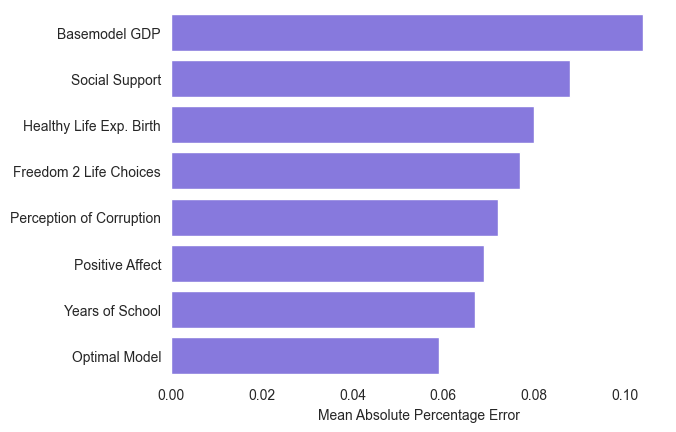

In [81]:
g=sns.barplot(data = metrics_df, y = 'model_name', x = 'test_mape', color = 'mediumslateblue')
g.set_xticklabels(g.get_xticklabels(), rotation=0)
for edge in ['right', 'top', 'left', 'bottom']:
    g.spines[edge].set_visible(False)
g.set(ylabel='')
g.set(xlabel='Mean Absolute Percentage Error')
plt.show();

Residual plots

<Axes: xlabel='life_ladder'>

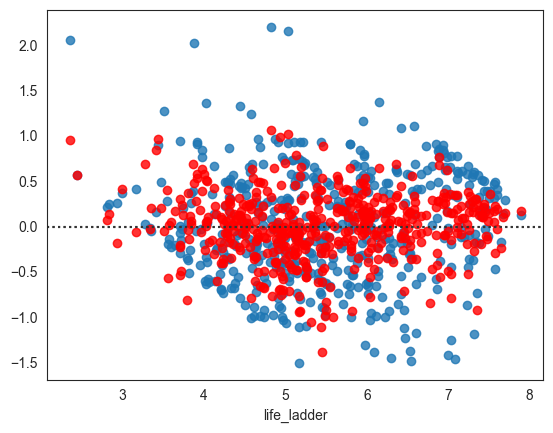

In [82]:
pred_values = knn_01.predict(X_test_scaled[:,[0]])
sns.residplot(x=y_test, y=pred_values)
pred_values = knn_opt.predict(X_test_scaled[:,[0,1,2,3,4,5,6]])
sns.residplot(x=y_test, y=pred_values, color = 'red')

Optimization with cross validation

In [83]:
knn_01.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 10,
 'p': 1,
 'weights': 'uniform'}

In [84]:
param_grid = {"algorithm": ["ball_tree", "kd_tree", "brute"],
              "leaf_size": np.arange(20,51,5).astype(int),
              "n_neighbors" : np.arange(5,26,1).astype(int),
              "p" : [1, 2, 3],
}
              

In [85]:
# 'neg_mean_absolute_error',
#'neg_mean_absolute_percentage_error',

In [86]:
gridsearch = RandomizedSearchCV(KNeighborsRegressor(),
                        param_grid,
                        scoring='neg_mean_absolute_percentage_error',
                        cv=5, verbose=5, n_jobs=-1,
                        n_iter=90, random_state=1234)

# Fit randomized search object to data
gridsearch.fit(X_train_scaled[:,[0,1,2,3,4,5,6]], y_train)

print('Best score:', round(gridsearch.best_score_, 3))
print('Best parameters:', gridsearch.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[CV 2/5] END algorithm=brute, leaf_size=50, n_neighbors=21, p=2;, score=-0.081 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=50, n_neighbors=21, p=2;, score=-0.067 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=50, n_neighbors=21, p=2;, score=-0.079 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=50, n_neighbors=21, p=2;, score=-0.081 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=50, n_neighbors=21, p=2;, score=-0.075 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=30, n_neighbors=16, p=3;, score=-0.066 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=16, p=3;, score=-0.079 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=30, n_neighbors=16, p=3;, score=-0.079 total time=   0.1s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=1;, score=-0.065 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=1;, score=-0.081 total time=   0.0s
[CV 3/5] END alg

In [87]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best = gridsearch.best_estimator_

# Making predictions on the test set
y_pred_test_best = knn_best.predict(X_test_scaled[:,[0,1,2,3,4,5,6]])


# Let us print out the performance of our model on the test set.
print('=======================')
print('n_neighbors: {}'.format(knn_best.n_neighbors))
print('weights: {}'.format(knn_best.weights))
print('p: {}'.format(knn_best.p))
print('algorithm: {}'.format(knn_best.algorithm))
print('=======================')
mae_test = mean_absolute_error(y_test, y_pred_test_best).round(3)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test_best).round(3)
print('Test mae: {:2f}'.format(mae_test))
print('Test mape: {:2f}'.format(mape_test))

n_neighbors: 5
weights: uniform
p: 1
algorithm: brute
Test mae: 0.294000
Test mape: 0.059000


Prediction of Happieness Index 2023

In [105]:
df_2023 = pd.read_csv("../data/life_ladder_2023.txt")
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_name                      118 non-null    object 
 1   year                              118 non-null    int64  
 2   life_ladder                       118 non-null    float64
 3   log_gdp_per_capita                118 non-null    float64
 4   social_support                    118 non-null    float64
 5   healthy_life_expectancy_at_birth  118 non-null    float64
 6   freedom_to_make_life_choices      118 non-null    float64
 7   perceptions_of_corruption         118 non-null    float64
 8   positive_affect                   118 non-null    float64
 9   mys_year                          118 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ KB


In [106]:
df_2023.life_ladder.value_counts()

life_ladder
4.292    2
5.910    2
3.588    2
6.553    2
5.445    1
        ..
5.104    1
6.557    1
7.699    1
4.093    1
3.572    1
Name: count, Length: 114, dtype: int64

In [107]:
features_2023 = df_2023[['log_gdp_per_capita',
       'social_support', 'healthy_life_expectancy_at_birth',
       'freedom_to_make_life_choices', 'perceptions_of_corruption',
       'positive_affect', 'mys_year']]

#features_2023.rename(columns = {'mys_2023':'mys_year'}, inplace=True)
features_2023

,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,perceptions_of_corruption,positive_affect,mys_year
0,9.689,0.691,69.2,0.872,0.855,0.597,9.903927
1,9.994,0.892,67.3,0.832,0.846,0.720,10.814714
2,9.730,0.819,68.2,0.819,0.681,0.575,11.242873
3,10.846,0.896,71.2,0.876,0.482,0.731,12.264984
4,10.930,0.874,71.4,0.874,0.529,0.712,11.981691
...,...,...,...,...,...,...,...
113,10.122,0.908,67.5,0.904,0.662,0.753,8.619942
114,9.026,0.909,65.9,0.927,0.650,0.752,11.490172
115,9.392,0.845,65.7,0.956,0.655,0.710,8.002617
116,8.115,0.664,56.1,0.854,0.814,0.653,6.647242


In [108]:
life_ladder_2023 = df_2023.life_ladder.copy()
life_ladder_2023

0      5.445
1      6.393
2      5.679
3      7.025
4      6.636
       ...  
113    6.662
114    6.385
115    6.325
116    3.686
117    3.572
Name: life_ladder, Length: 118, dtype: float64

In [109]:
y_pred_2023 = knn_opt.predict(scaler.transform(features_2023))
y_pred_2023

array([5.1662, 6.0936, 5.455 , 7.0534, 7.133 , 5.0846, 3.9542, 7.0346,
       4.5474, 5.358 , 5.5966, 4.6766, 5.199 , 5.4884, 4.7   , 4.418 ,
       4.7454, 6.918 , 4.3536, 6.3516, 5.9266, 4.8056, 5.3016, 3.9788,
       6.9454, 6.1758, 6.9896, 7.4606, 6.1388, 5.7436, 6.3772, 7.0748,
       4.0064, 7.6258, 6.7078, 4.9388, 4.3618, 5.3052, 7.0344, 4.4062,
       5.9572, 6.1904, 4.8976, 5.906 , 6.0924, 7.4982, 4.7502, 5.3198,
       4.9102, 4.9144, 7.0394, 7.1074, 6.3608, 4.7024, 6.0178, 4.8176,
       6.0626, 4.8772, 5.6928, 5.0036, 6.2396, 4.1558, 4.2118, 6.339 ,
       7.0056, 4.0368, 3.5926, 5.9652, 4.7392, 4.4144, 5.8714, 6.6568,
       5.6014, 5.562 , 5.5844, 4.9358, 4.4034, 4.7666, 4.9082, 5.1446,
       7.3516, 7.1926, 6.2044, 4.3804, 5.6768, 7.4436, 4.8262, 6.3912,
       6.5322, 5.6466, 5.3814, 6.2652, 5.874 , 6.4024, 4.8216, 5.7326,
       3.3458, 6.3566, 6.348 , 4.6142, 6.0372, 6.4098, 5.3884, 7.3724,
       7.4996, 6.4002, 4.196 , 4.4698, 5.2028, 4.3642, 5.164 , 6.8552,
      

In [110]:
pd.DataFrame({'life_ladder_prediction' : y_pred_2023})

,life_ladder_prediction
0,5.1662
1,6.0936
2,5.4550
3,7.0534
4,7.1330
...,...
113,6.3846
114,6.0124
115,5.8374
116,4.1756


In [111]:
scaled_feature_2023 = scaler.transform(features_2023)

In [112]:
y_pred_2023_basem = knn_01.predict(scaled_feature_2023[:,[0]])
pd.DataFrame({'life_ladder_prediction_basemodel' : y_pred_2023_basem})

,life_ladder_prediction_basemodel
0,6.0219
1,5.6597
2,5.3674
3,7.3817
4,7.3829
...,...
113,5.8136
114,5.5166
115,5.4298
116,4.4678


In [113]:
df_2023_with_prediction = pd.concat([df_2023,
                                     pd.DataFrame({'life_ladder_prediction' : y_pred_2023}),
                                     pd.DataFrame({'life_ladder_prediction_basemodel' : y_pred_2023_basem})],
                                     axis = 1)
df_2023_with_prediction

,country_name,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,perceptions_of_corruption,positive_affect,mys_year,life_ladder_prediction,life_ladder_prediction_basemodel
0,Albania,2023,5.445,9.689,0.691,69.2,0.872,0.855,0.597,9.903927,5.1662,6.0219
1,Argentina,2023,6.393,9.994,0.892,67.3,0.832,0.846,0.720,10.814714,6.0936,5.6597
2,Armenia,2023,5.679,9.730,0.819,68.2,0.819,0.681,0.575,11.242873,5.4550,5.3674
3,Australia,2023,7.025,10.846,0.896,71.2,0.876,0.482,0.731,12.264984,7.0534,7.3817
4,Austria,2023,6.636,10.930,0.874,71.4,0.874,0.529,0.712,11.981691,7.1330,7.3829
...,...,...,...,...,...,...,...,...,...,...,...,...
113,Uruguay,2023,6.662,10.122,0.908,67.5,0.904,0.662,0.753,8.619942,6.3846,5.8136
114,Uzbekistan,2023,6.385,9.026,0.909,65.9,0.927,0.650,0.752,11.490172,6.0124,5.5166
115,Vietnam,2023,6.325,9.392,0.845,65.7,0.956,0.655,0.710,8.002617,5.8374,5.4298
116,Zambia,2023,3.686,8.115,0.664,56.1,0.854,0.814,0.653,6.647242,4.1756,4.4678


<Axes: xlabel='life_ladder', ylabel='life_ladder_prediction'>

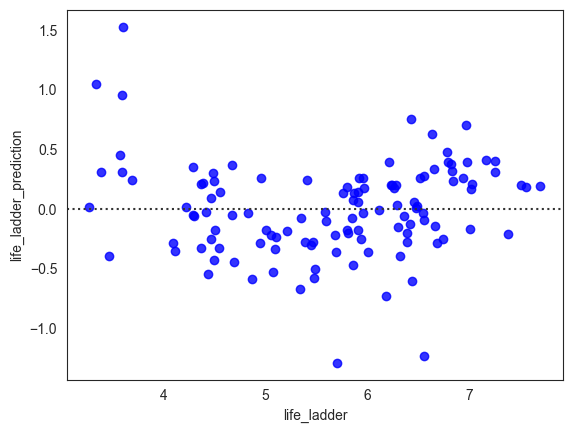

In [114]:
sns.residplot(data= df_2023_with_prediction,
              x='life_ladder', y='life_ladder_prediction', color = 'blue')
#sns.residplot(data= df_2023_with_prediction,
#              x='life_ladder', y='life_ladder_prediction_basemodel', color = 'red')

/Users/maritaschmidt/NEUE_FISCHE/Capstone_Happy_Almana/.venv/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0),

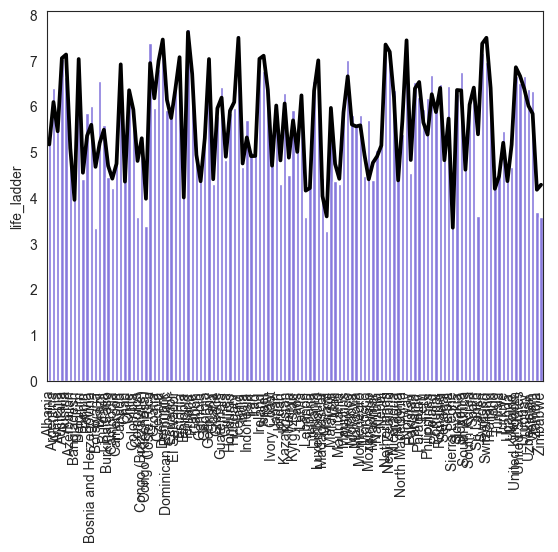

In [115]:
#g=sns.lineplot(data = metrics_df, x = 'model_name', y = 'test_r2', color = 'darkorange')
g=sns.barplot(data = df_2023_with_prediction,
               x = 'country_name', y = 'life_ladder', color = 'mediumslateblue')
g=sns.pointplot(data = df_2023_with_prediction,
               x = 'country_name', y = 'life_ladder_prediction', color = 'black', markers = '')
#g=sns.lineplot(data = df_2023_with_prediction,
#               x = 'country_name', y = 'life_ladder_prediction_basemodel', color = 'red')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylabel='life_ladder')
g.set(xlabel='')
plt.show();

In [116]:
mae_2033_basemodel = mean_absolute_error(life_ladder_2023, y_pred_2023_basem).round(3)
mape_2033_basemodel = mean_absolute_percentage_error(life_ladder_2023, y_pred_2023_basem).round(3)
mae_2033_prediction = mean_absolute_error(life_ladder_2023, y_pred_2023).round(3)
mape_2033_prediction = mean_absolute_percentage_error(life_ladder_2023, y_pred_2023).round(3)

print(mae_2033_basemodel,mape_2033_basemodel)

print(mae_2033_prediction,mape_2033_prediction)

0.521 0.101
0.299 0.059


Just Europe

In [117]:
europe =['Russia', 'Norway', 'France', 'Sweden', 'Belarus', 'Ukraine',
       'Poland', 'Austria', 'Hungary', 'Moldova', 'Romania', 'Lithuania',
       'Latvia', 'Estonia', 'Germany', 'Bulgaria', 'Greece', 'Albania',
       'Croatia', 'Switzerland', 'Luxembourg', 'Belgium', 'Netherlands',
       'Portugal', 'Spain', 'Ireland', 'Italy', 'Denmark',
       'United Kingdom', 'Iceland', 'Slovenia', 'Finland', 'Slovakia',
       'Czechia', 'Bosnia and Herzegovina', 'North Macedonia', 'Serbia',
       'Montenegro', 'Kosovo']

In [118]:
df_ll_europe_2023 = pd.concat(df_2023_with_prediction[df_2023_with_prediction['country_name'] == item] for item in europe)
df_ll_europe_2023[['country_name','life_ladder', 'life_ladder_prediction','life_ladder_prediction_basemodel']]

,country_name,life_ladder,life_ladder_prediction,life_ladder_prediction_basemodel
85,Norway,7.249,7.4436,7.4229
34,France,6.557,6.7078,7.2413
103,Sweden,7.161,7.3724,7.2114
110,Ukraine,4.672,5.1640,5.1878
91,Poland,6.685,6.2652,6.5841
4,Austria,6.636,7.1330,7.3829
44,Hungary,5.965,6.0924,6.4356
72,Moldova,5.801,5.6014,5.1342
93,Romania,6.489,6.4024,6.3584
63,Lithuania,6.553,6.3390,6.6445


In [119]:
df_ll_europe_2023.to_csv('../data/life_ladder_predicted_2023_europe.txt', index=False)

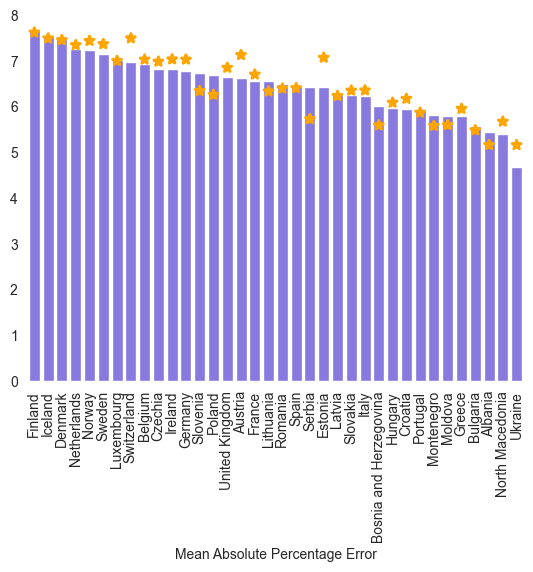

In [120]:
g=sns.barplot(data = df_ll_europe_2023.sort_values(by='life_ladder', ascending = False),
              x = 'country_name', y = 'life_ladder', color = 'mediumslateblue')
g = sns.pointplot(data = df_ll_europe_2023.sort_values(by='life_ladder', ascending = False),
              x = 'country_name', y = 'life_ladder_prediction', color = 'orange',
              markers='*', linestyles='')

g.set_xticklabels(g.get_xticklabels(), rotation=90)
for edge in ['right', 'top', 'left', 'bottom']:
    g.spines[edge].set_visible(False)
g.set(ylabel='')
g.set(xlabel='Mean Absolute Percentage Error')
plt.show();

KNN Symbolplot

/var/folders/m_/n8mjr4pn3vl8nz5my8xxr76r0000gn/T/ipykernel_44282/3139364166.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['0','2','4','6','8','10'])
/var/folders/m_/n8mjr4pn3vl8nz5my8xxr76r0000gn/T/ipykernel_44282/3139364166.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['0','20','40','60','80','100'])


[Text(0, 3.0, '0'),
 Text(0, 4.0, '20'),
 Text(0, 5.0, '40'),
 Text(0, 6.0, '60'),
 Text(0, 7.0, '80'),
 Text(0, 8.0, '100')]

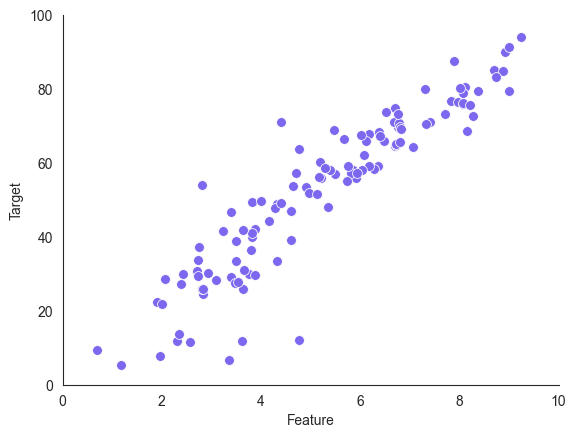

In [121]:
g=sns.scatterplot(data=df_2023_with_prediction,
                x='life_ladder_prediction',
                y='life_ladder',
                color= 'mediumslateblue',
                s=50)
for edge in ['right', 'top']:
    g.spines[edge].set_visible(False)
g.set(ylabel='Target')
g.set(xlabel='Feature')
g.set_xlim(3, 8)
g.set_ylim(3, 8)
g.set_xticklabels(['0','2','4','6','8','10'])
g.set_yticklabels(['0','20','40','60','80','100'])